# Libraries

In [80]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src.models import decoders
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Numerical Model

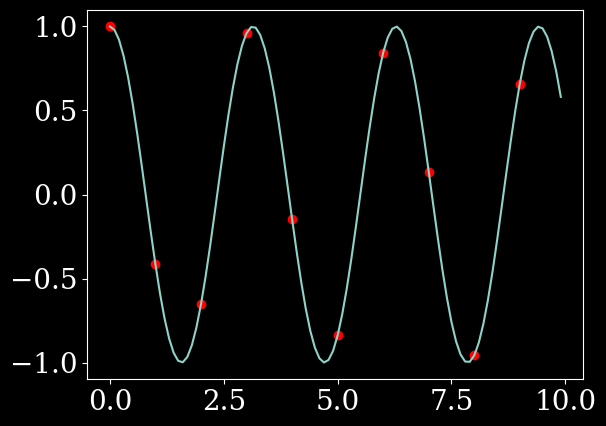

0.5


In [79]:
t = np.arange(0,10, 0.1)

y = np.cos(2*t)

t_s = np.arange(0,10, 1)

y_s = np.cos(2*t_s)

plt.plot(t, y)
plt.scatter(t_s, y_s,c='r')

plt.show()

print(t[5]-t[0])

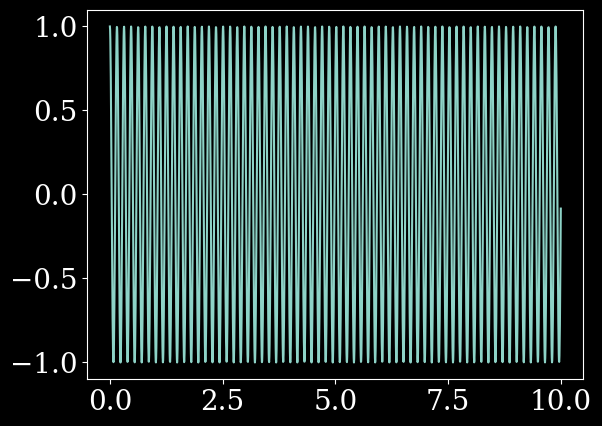

In [94]:
y_list =[]

y0 = y[0]
y1 = y[1]

y_list.append(y0)
y_list.append(y1)

dt = 0.1*1

for i in range(2, len(t)):
    
    y2 = y1 +(y1 - y0) - dt*dt*4*y1

    y_list.append(y2)
    y0 = y1
    y1 = y2
    

y_list = np.array(y_list)

plt.plot(t, y_list)
plt.show()

# Pendulum

### Load Data

In [2]:
t,a = genData.generateDynamics(0.5,(-0.5))
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion")

<Figure size 640x480 with 0 Axes>

### Visualizations

In [70]:
genData.generateVideo(a,DynamicsType = "Motion", name = "Pendulum_Original_video")

Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


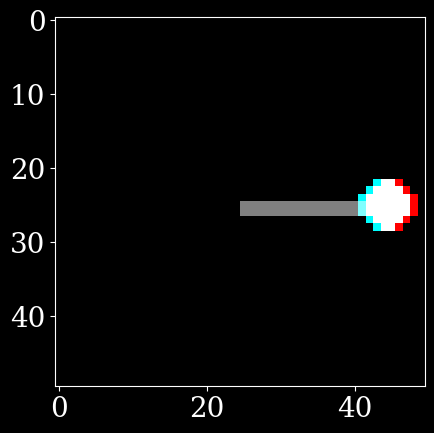

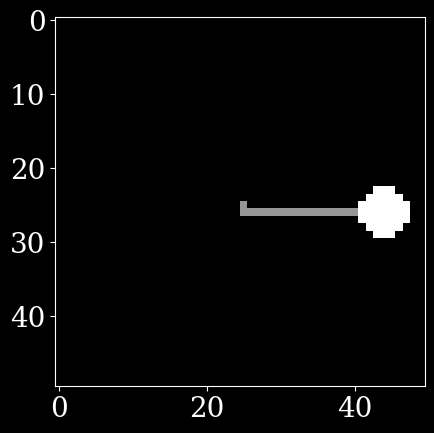

In [71]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type="Motion")

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model 

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

In [13]:
visual_loader= loader.getLoader(a, type="Motion", split=False)
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')
vu.CompareLatent(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

### Test Decoder

In [25]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Motion")
linearDecoder = decoders.convDecoder(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='decoder_loss')

Using device: cuda


pred_img.shape torch.Size([32, 1, 20, 20])
expected_pred.shape torch.Size([32, 50, 50])


RuntimeError: The size of tensor a (20) must match the size of tensor b (50) at non-singleton dimension 3

In [4]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Motion")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Motion_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Motion_Decoder_ExpVsPred.mp4


# Intensity

In [101]:

t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,   dt=1/100, nInFrames = 5,sr = 10 ,  noise=False, shapeType='simple')
#print(train_x.shape)
#print(val_x.shape)
#print(len(train_dataloader))
#print(len(test_dataloader))

<Figure size 640x480 with 0 Axes>

### Visuals

In [65]:
genData.generateVideo(a,DynamicsType = "Intensity", name = "Intensity_Original_video")

(10000,)


<function matplotlib.pyplot.show(close=None, block=None)>

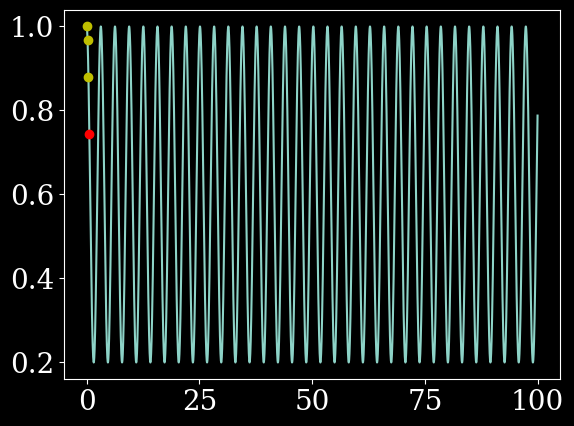

In [106]:
print(a.shape)

plt.figure()
plt.plot(t,a)
sr = 20
for i in range(4):
    if i == 3:
        plt.plot(t[i*sr],a[i*sr],'ro')
    else:
        plt.plot(t[i*sr],a[i*sr],'yo')

plt.show

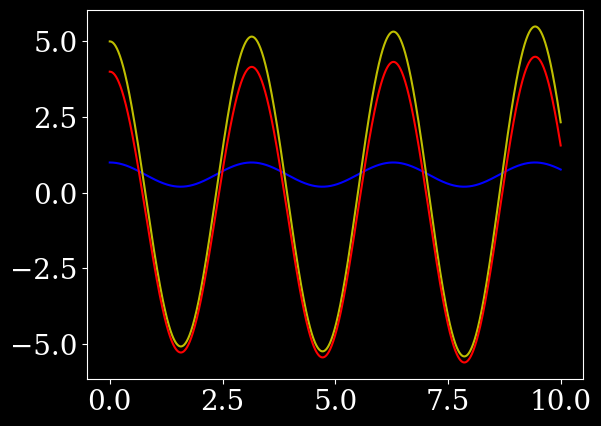

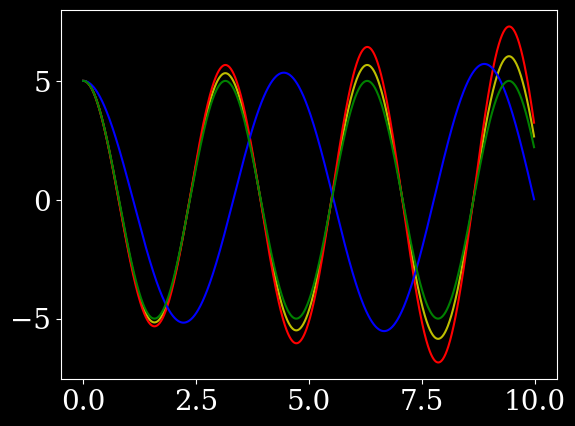

In [49]:
yd = np.zeros(2000)
yd[0]= a[0]*5
yd[1] = a[1]*5
yd[2] = a[2]*5

dt = 1/200

for i in range(2000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

plt.figure()
plt.plot(t,a,'b')
plt.plot(t,yd,'y')
plt.plot(t,yd-a,'r')
plt.show()

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

    td[i+3] = td[i+2] + dt

plt.figure()

plt.plot(td,yd,'y')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'r')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y1-y0) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'b')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()
    

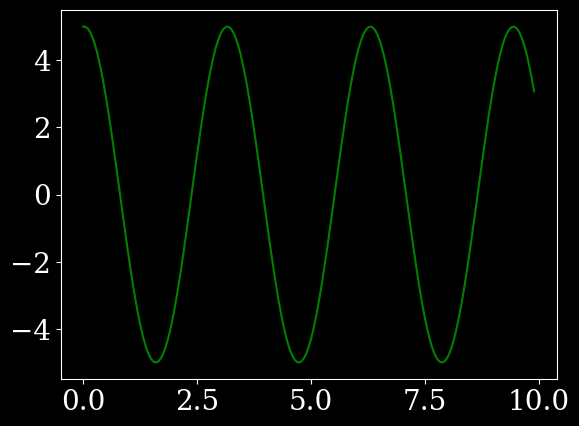

In [50]:
yd = np.zeros(200)
td = np.zeros(200)

td[0]= t[0]
td[1] = t[10]
td[2] = t[10]

yd[0]= a[0]*5
yd[1] = a[10]*5
yd[2] = a[10]*5

dt = 10/200

for i in range(200-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()

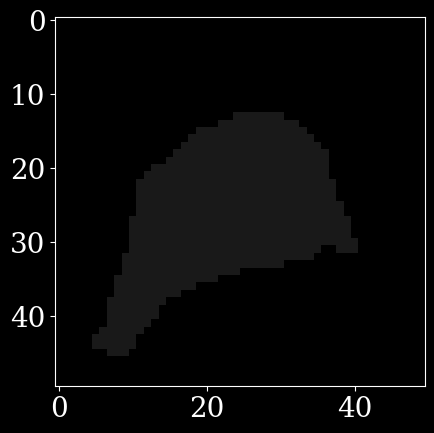

In [51]:
aa = genData.create_intensity_image(0.1, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)


Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


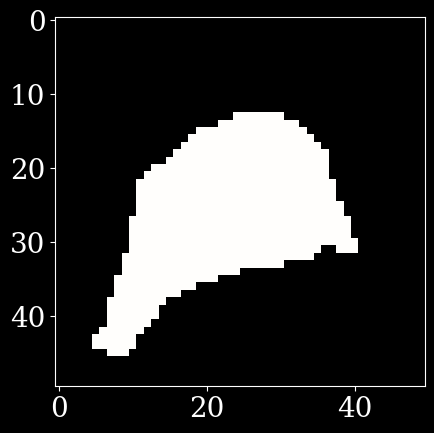

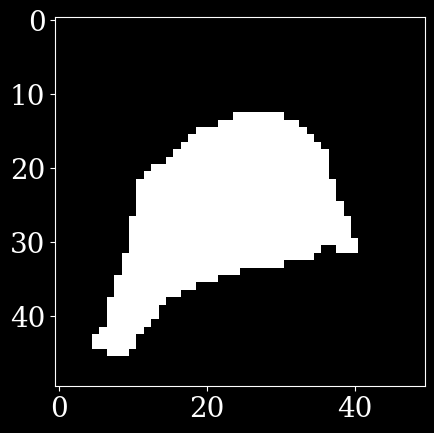

In [9]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][30,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

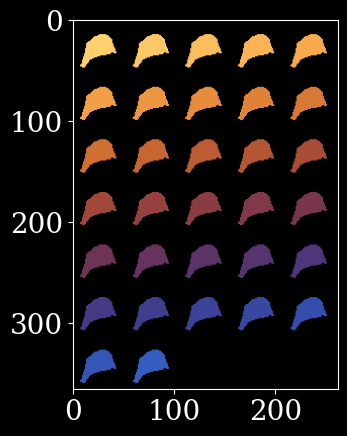

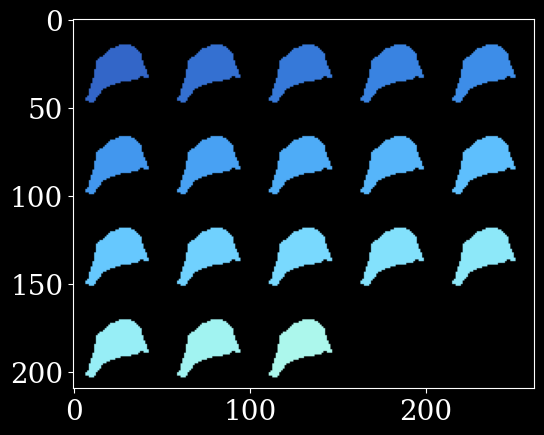

In [8]:
vu.visualize_loader(train_dataloader)

### Model

In [77]:


modelfull= modelineal.AE(dt=0.05, initw=True)
#modelfull= mainmodel.AEModel(dt=0.25, initw=True)#
modelfull, train_losses, val_losses, accuracy_list  = train.train(modelfull, train_dataloader, test_dataloader, 'fullmodel', type='encoder-decoder')



Using device: cpu


epoch: 10 	 training loss: 0.02393619288865011 	 validation loss: 0.27576659790550667
epoch: 20 	 training loss: 0.023681869482970797 	 validation loss: 0.11160225436712305
epoch: 30 	 training loss: 0.023644985924474896 	 validation loss: 0.07640182816733916
epoch: 40 	 training loss: 0.02363846118620131 	 validation loss: 0.06261550278092425
epoch: 50 	 training loss: 0.02367048117215745 	 validation loss: 0.057478685242434345
epoch: 60 	 training loss: 0.023703070355113594 	 validation loss: 0.05563825694844127
epoch: 70 	 training loss: 0.02370201895420905 	 validation loss: 0.05281480976069967
epoch: 80 	 training loss: 0.02352042862563394 	 validation loss: 0.047235113413383566
epoch: 90 	 training loss: 0.023520257283817046 	 validation loss: 0.04210684293260177
epoch: 100 	 training loss: 0.023377364840125665 	 validation loss: 0.0411520516499877


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,4.0
beta,0.0
train_loss,0.02338
validation_loss,0.04115


<Figure size 640x480 with 0 Axes>

In [55]:
for name, param in modelfull.named_parameters():
    print(name, param.shape, param.requires_grad)

print(modelfull.pModel.alpha[0])
print(modelfull.pModel.beta[0]) 

encoder.linear.0.weight torch.Size([1000, 2500]) True
encoder.linear.0.bias torch.Size([1000]) True
encoder.linear.1.weight torch.Size([500, 1000]) True
encoder.linear.1.bias torch.Size([500]) True
encoder.linear.2.weight torch.Size([1, 500]) True
encoder.linear.2.bias torch.Size([1]) True
decoder.l1.weight torch.Size([10, 1]) True
decoder.l2.weight torch.Size([1000, 10]) True
decoder.l3.weight torch.Size([2500, 1000]) True
pModel.alpha torch.Size([1]) False
pModel.beta torch.Size([1]) False
tensor(4.)
tensor(0.)


In [34]:
def phyModel(y1, y2, dt):
    alpha = 4
    return y2 + (y2-y1) - dt*dt*(alpha*y1)

print(phyModel( 0.9980, 0.9920, 0.05))

0.97602


In [74]:
visual_loader= loader.getLoaderIn(a,  split = False, type = "Dataset3d",  dt=0.05,nInFrames = 3,sr = 10 ,   noise=False, shapeType='simple')
vu.visualize(modelfull, visual_loader, video_name = 'neuronFullModel_ExpVsPred.mp4')
vu.CompareLatent(modelfull, visual_loader)

### Test Decoder

In [82]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Intensity")
linearDecoder = decoders.mlp(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Intensity_Decoder', loss_name='decoder_loss')

Using device: cpu


pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch.Size([32, 50, 50])
pred_img.shape torch.Size([32, 50, 50])
expected_pred.shape torch

KeyboardInterrupt: 

In [131]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Intensity")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Intensity_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Intensity_Decoder_ExpVsPred.mp4


### Test encoder decoer

In [111]:
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,   dt=1/100, nInFrames = 5,sr = 20 ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Intensity_Decoder', loss_name='latent_loss')

Using device: cpu


epoch: 10 	 training loss: 0.11099084028747944 	 validation loss: 5.826135949293772
epoch: 20 	 training loss: 0.09545143137071828 	 validation loss: 5.859777935345968
epoch: 30 	 training loss: 0.09110349226744868 	 validation loss: 5.860901172955831
epoch: 40 	 training loss: 0.09300445101948772 	 validation loss: 6.033600191275279
epoch: 50 	 training loss: 0.12047874248258558 	 validation loss: 5.868782027562459
epoch: 60 	 training loss: 0.10370404753732204 	 validation loss: 6.127106980482737
epoch: 70 	 training loss: 0.08184196565560393 	 validation loss: 6.067840961615245
epoch: 80 	 training loss: 0.09657052991466845 	 validation loss: 5.864679356416066
epoch: 90 	 training loss: 0.08147750772547113 	 validation loss: 5.877435362339019
epoch: 100 	 training loss: 0.09377852803791839 	 validation loss: 5.878034019470215


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▇▆▇▆▇▇▇▇▇▇▅▆▄▆█▇▅▆▅█▇▅▃▆▇▅▇▇▆▅▇▅▁█▇▆█▇▆▇
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▄▂▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂▂▁▂▁▁▁▁▁▂▁▂▂▁▂▁▁ ▂▁▁▁
alpha,3.85421
beta,1.0
train_loss,0.09378
validation_loss,5.87803


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [113]:
visual_loader= loader.getLoader(a,type="Intensity", split = False,   dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

# Scale

In [105]:
t,a = genData.generateDynamics(max=1, min = 0)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')

<Figure size 640x480 with 0 Axes>

In [106]:
genData.generateVideo(a,DynamicsType = "Scale", name = "Scale_Original_video")

### Test Decoder

In [108]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Scale")
linearDecoder = decoders.mlp(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Scale_Decoder', loss_name='decoder_loss')

Using device: cuda


epoch: 10 	 training loss: 0.05719152551144362 	 validation loss: 0.03342188042230331
epoch: 20 	 training loss: 0.056892652474343774 	 validation loss: 0.03397236556674425
epoch: 30 	 training loss: 0.056780308820307254 	 validation loss: 0.03567916749475094
epoch: 40 	 training loss: 0.05668225105851889 	 validation loss: 0.03647880177371777
epoch: 50 	 training loss: 0.05665849100798368 	 validation loss: 0.03686625983279485
epoch: 60 	 training loss: 0.056596668548882005 	 validation loss: 0.03693357468224489
epoch: 70 	 training loss: 0.05653765968978405 	 validation loss: 0.03708248571134531
epoch: 80 	 training loss: 0.05646611392498016 	 validation loss: 0.03717367028674254
epoch: 90 	 training loss: 0.05635320872068405 	 validation loss: 0.03733219607518269
epoch: 100 	 training loss: 0.056242847628891465 	 validation loss: 0.037558308229423486


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.05624
validation_loss,0.03756


<Figure size 640x480 with 0 Axes>

In [109]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Scale")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Scale_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Scale_Decoder_ExpVsPred.mp4


# Test

In [21]:
# Assuming batch size is 32 and images are grayscale with dimensions (height, width)
batch_size = 32
height, width = 28, 28  # Example dimensions, adjust as per your images

# Generate a random batch of images (example)
batch_images = torch.rand(batch_size, height, width)

# Reshape the batch to (batch_size, num_pixels)
batch_images_flat = batch_images.view(batch_size, -1)

print(batch_images_flat.shape)
print(batch_images.shape)

# Calculate the variance across the batch for each pixel
variances = torch.var(batch_images_flat, dim=0)

print(variances.shape)

torch.Size([32, 784])
torch.Size([32, 28, 28])
torch.Size([784])


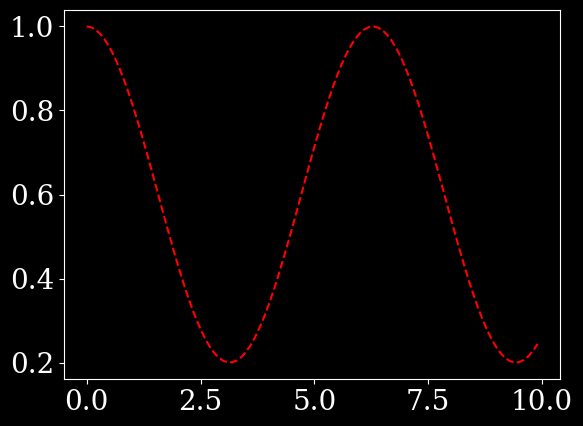

In [40]:
t = np.arange(0,10, 0.1)
m = (1-0.2)/(1-(-1))
b= 1 - m
x = m*np.cos(t)+b

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = 0.1
for i in range(2, len(t)):
    y2 = y1+ (y1-y0) -dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'--r')
#plt.plot(t,y,'--b')
plt.show()


In [ ]:

t = np.arange(0,2*np.pi, np.pi/100)
x = np.cos(t)

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = np.pi/100
for i in range(2, len(t)):
    y2 = y1+ (y1-y0)*dt +dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'r')
plt.plot(t,y,'b')
plt.show()

## Plots

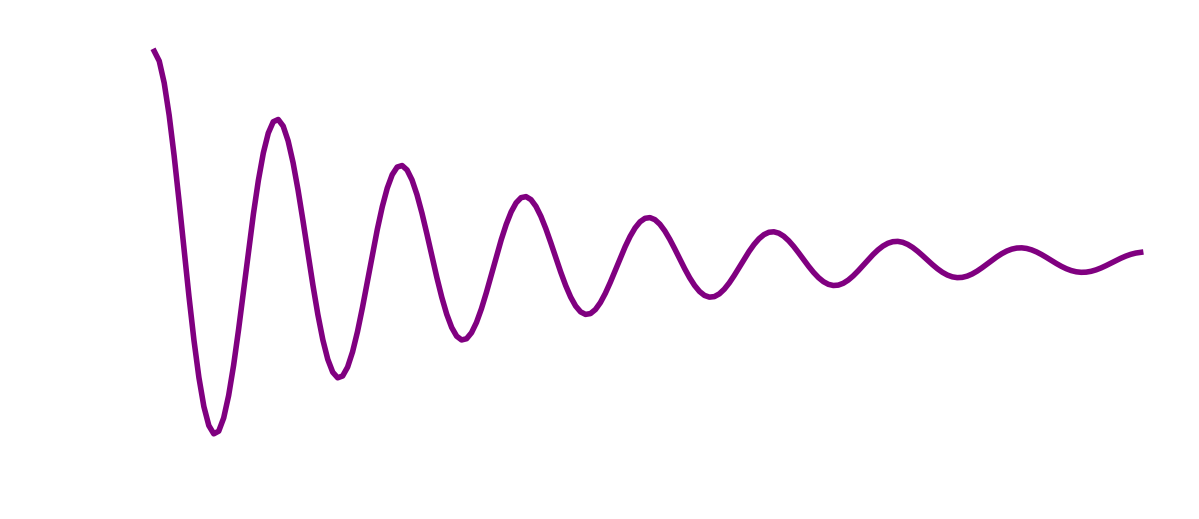

In [25]:
t = np.arange(0,2*np.pi, np.pi/100)
x = np.exp(-0.5*t)*np.cos(8*t) 

plt.figure(figsize=(14, 6))

plt.plot(t, x, linewidth=4, color='purple')


plt.ylim(-1, 1.2)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()

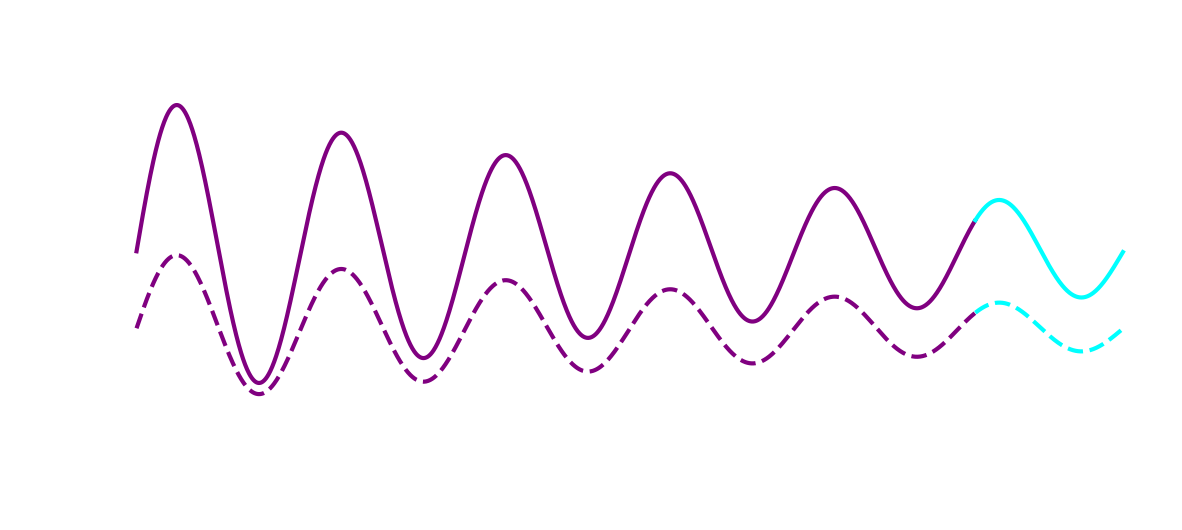

In [51]:
t = np.arange(0,2*np.pi, np.pi/1000)
x = np.exp(-0.2*t)*np.sin(6*t)
x2 = 0.5*x-0.5


plt.figure(figsize=(14, 6))

testat = 300

plt.plot(t[0:-testat], x[0:-testat], linewidth=3, color='purple')
plt.plot(t[0:-testat], x2[0:-testat], linewidth=3, color='purple', linestyle='--')

plt.plot(t[-testat::], x[-testat::], linewidth=3, color='cyan')
plt.plot(t[-testat::], x2[-testat::], linewidth=3, color='cyan', linestyle='--')


plt.ylim(-1.5, 1.5)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()